# Config

In [1]:
from comet_ml import Experiment
import scanpy as sc
import scirpy as ir
import pandas as pd
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [3]:
CONFIG_NAME = 'random_baseline'
RANDOM_SEED = 42
experiment_name = '10x_' + CONFIG_NAME + '_seed_' + str(RANDOM_SEED)
zdim = 100
np.random.seed(RANDOM_SEED)

In [4]:
experiment_name

'10x_random_baseline_seed_42'

In [5]:
%load_ext autoreload
%autoreload 2

# Load dataset

### 10x Dataset

In [6]:
adata = sc.read_h5ad('../data/10x_CD8TC/v5_train_val_test.h5ad')
adata

AnnData object with n_obs × n_vars = 128587 × 5000
    obs: 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 'IgG2b

### Split data into train and val, filter out test set to keep it untouched

In [7]:
adata.obs['set'].value_counts() / len(adata)

train    0.681577
test     0.162987
val      0.155436
Name: set, dtype: float64

In [8]:
adata = adata[adata.obs['set'] != 'test']
adata.obs['set'].value_counts() / len(adata)

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


train    0.814297
val      0.185703
Name: set, dtype: float64

In [9]:
train_adata = adata[adata.obs['set'] == 'train']
val_adata = adata[adata.obs['set'] == 'val']

#### Comet ML

In [10]:
with open('../comet_ml_key/API_key.txt') as f:
    COMET_ML_KEY = f.read()

experiment = Experiment(api_key=COMET_ML_KEY, workspace='tcr', project_name='10x_baseline')
experiment.log_parameters({'random_seed': RANDOM_SEED, 
                           'zdim': zdim})
experiment.log_parameter('experiment_name', experiment_name)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/tcr/10x-baseline/06815a2a65d34e2d8b9e3ace8d67c0a6



# UMAP Plot of latent space

In [11]:
# List of antigens from David Fischer's paper, basically the 8 most common antigens
high_antigen_count = ['A0201_ELAGIGILTV_MART-1_Cancer_binder', 
                      'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 
                      'A0201_GLCTLVAML_BMLF1_EBV_binder', 
                      'A0301_KLGGALQAK_IE-1_CMV_binder', 
                      'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 
                      'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 
                      'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 
                      'B0801_RAKFKQLL_BZLF1_EBV_binder']

### On Val Data

Filter cells with no binding data and only UMAP on high count antigen bindings

In [12]:
val_adata = val_adata[val_adata.obs['has_binding']]

In [13]:
val_adata.obs['binding_name'].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder                4228
B0801_RAKFKQLL_BZLF1_EBV_binder                1344
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder            1211
A0201_GILGFVFTL_Flu-MP_Influenza_binder        1000
A1101_IVTDFSVIK_EBNA-3B_EBV_binder              150
A0201_GLCTLVAML_BMLF1_EBV_binder                 84
A0301_RLRAEAQVK_EMNA-3A_EBV_binder               59
A0201_ELAGIGILTV_MART-1_Cancer_binder            48
A0201_FLYALALLL_LMP2A_EBV_binder                 31
B0801_FLRGRAYGL_EBNA-3A_EBV_binder               22
A0201_LLDFVRFMGV_EBNA-3B_EBV_binder               7
A2402_AYAQKIFKI_IE-1_CMV_binder                   6
A0201_SLFNTVATLY_Gag-protein_HIV_binder           6
A0201_RTLNAWVKV_Gag-protein_HIV_binder            6
A0201_LLFGYPVYV_HTLV-1_binder                     5
A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder       4
A0201_KTWGQYWQV_gp100_Cancer_binder               3
A0201_MLDLQPETT_16E7_HPV_binder                   2
A0201_KVLEYVIKV_MAGE-A1_Cancer_binder             2
A2402_CYTWNQ

In [14]:
val_adata

View of AnnData object with n_obs × n_vars = 8227 × 5000
    obs: 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 

In [15]:
z_val = sc.AnnData(np.random.randn(len(val_adata), zdim))
z_val.obs.index = val_adata.obs.index
z_val.obs[high_antigen_count] = val_adata.obs[high_antigen_count]
z_val.obs['binding_name'] = val_adata.obs['binding_name']
z_val.obs['binding_label'] = val_adata.obs['binding_label']
z_val.obs

,A0201_ELAGIGILTV_MART-1_Cancer_binder,A0201_GILGFVFTL_Flu-MP_Influenza_binder,A0201_GLCTLVAML_BMLF1_EBV_binder,A0301_KLGGALQAK_IE-1_CMV_binder,A0301_RLRAEAQVK_EMNA-3A_EBV_binder,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,binding_name,binding_label
ACGGAGAAGGCGATAC-1-donor_1,False,False,False,False,False,False,True,False,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,33
ACTGCTCTCGAGAGCA-1-donor_1,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
AGCTCTCTCCCTTGCA-1-donor_1,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
CGGCTAGTCATGTCCC-1-donor_1,False,False,False,False,False,False,True,False,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,33
CGTTAGATCGGAAATA-1-donor_1,False,False,False,False,False,False,True,False,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,33
...,...,...,...,...,...,...,...,...,...,...
ATTGGACGTCTCTCGT-8-donor_4,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
GTCATTTGTCTGGAGA-8-donor_4,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
GTGCTTCAGCACGCCT-8-donor_4,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
TCATTACTCTATCGCC-8-donor_4,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29


In [16]:
z_val

AnnData object with n_obs × n_vars = 8227 × 100
    obs: 'A0201_ELAGIGILTV_MART-1_Cancer_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'binding_name', 'binding_label'

In [17]:
sc.pp.neighbors(z_val, use_rep='X')
sc.tl.umap(z_val)

<ipython-input-18-8bafabc975c0>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  ax.tight_layout()


{'web': 'https://www.comet.ml/api/image/download?imageId=464d10cb04c74f6e9dbe476a77588a66&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=464d10cb04c74f6e9dbe476a77588a66&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'imageId': '464d10cb04c74f6e9dbe476a77588a66'}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

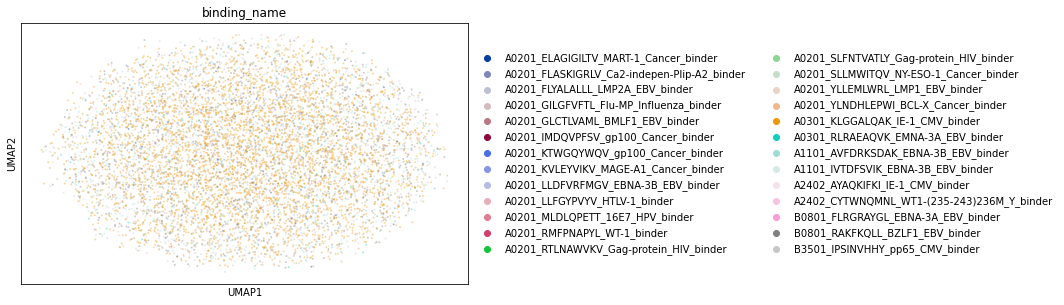

In [18]:
for antigen in high_antigen_count:
    ax = sc.pl.umap(z_val, color=antigen, return_fig=True, alpha=0.3)
    ax.tight_layout()
    experiment.log_figure(figure_name=f'val_{antigen}', figure=ax, overwrite=False)
    ax.clf()
ax = sc.pl.umap(z_val, color='binding_name', return_fig=True, alpha=0.4)
ax.set_size_inches(8, 4.8)
ax.tight_layout()
experiment.log_figure(figure_name=f'val_binding_name', figure=ax, overwrite=False)

### On Train Data

Filter cells with no binding data and only UMAP on high count antigen bindings

In [19]:
train_adata = train_adata[train_adata.obs['has_binding']]

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
train_adata.obs['binding_name'].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder                    17792
B0801_RAKFKQLL_BZLF1_EBV_binder                    12979
A1101_IVTDFSVIK_EBNA-3B_EBV_binder                  5390
A0201_GILGFVFTL_Flu-MP_Influenza_binder             5142
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder                 1929
A0201_GLCTLVAML_BMLF1_EBV_binder                    1027
A0301_RLRAEAQVK_EMNA-3A_EBV_binder                   245
A0201_ELAGIGILTV_MART-1_Cancer_binder                144
A0201_LLDFVRFMGV_EBNA-3B_EBV_binder                  114
A0201_FLYALALLL_LMP2A_EBV_binder                      55
A0201_RTLNAWVKV_Gag-protein_HIV_binder                22
A0201_LLFGYPVYV_HTLV-1_binder                         19
A0201_SLFNTVATLY_Gag-protein_HIV_binder               16
A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder           14
A2402_AYAQKIFKI_IE-1_CMV_binder                       12
A2402_QYDPVAALF_pp65_CMV_binder                        9
B0801_FLRGRAYGL_EBNA-3A_EBV_binder                     8
A0201_KTWGQYWQV_gp100_Cancer_bi

In [21]:
train_adata

View of AnnData object with n_obs × n_vars = 44979 × 5000
    obs: 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a',

In [22]:
z_train = sc.AnnData(np.random.randn(len(train_adata), zdim))
z_train.obs.index = train_adata.obs.index
z_train.obs[high_antigen_count] = train_adata.obs[high_antigen_count]
z_train.obs['binding_name'] = train_adata.obs['binding_name']
z_train.obs['binding_label'] = train_adata.obs['binding_label']
z_train.obs

,A0201_ELAGIGILTV_MART-1_Cancer_binder,A0201_GILGFVFTL_Flu-MP_Influenza_binder,A0201_GLCTLVAML_BMLF1_EBV_binder,A0301_KLGGALQAK_IE-1_CMV_binder,A0301_RLRAEAQVK_EMNA-3A_EBV_binder,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,binding_name,binding_label
AACTTTCAGTAACCCT-1-donor_1,False,False,False,False,False,True,False,False,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,32
ACACCCTAGGAGTTTA-1-donor_1,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
ACGAGGAGTCAATGTC-1-donor_1,False,True,False,False,False,False,False,False,A0201_GILGFVFTL_Flu-MP_Influenza_binder,14
ACGATACGTATATGGA-1-donor_1,False,False,False,False,False,True,False,False,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,32
ACGCAGCTCCCAAGAT-1-donor_1,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
...,...,...,...,...,...,...,...,...,...,...
TAAGAGATCCGTTGCT-8-donor_4,False,False,False,False,False,True,False,False,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,32
TAGACCATCGCGCCAA-8-donor_4,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29
TGACTTTCAATGAATG-8-donor_4,False,False,False,False,False,True,False,False,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,32
TGGCTGGGTCGACTAT-8-donor_4,False,False,False,True,False,False,False,False,A0301_KLGGALQAK_IE-1_CMV_binder,29


In [23]:
z_train

AnnData object with n_obs × n_vars = 44979 × 100
    obs: 'A0201_ELAGIGILTV_MART-1_Cancer_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'binding_name', 'binding_label'

In [24]:
sc.pp.neighbors(z_train, use_rep='X')
sc.tl.umap(z_train)

<ipython-input-25-f872def764f4>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  ax.tight_layout()


{'web': 'https://www.comet.ml/api/image/download?imageId=8ca811b4305046fa84b9f2fdfaf1d9f7&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=8ca811b4305046fa84b9f2fdfaf1d9f7&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'imageId': '8ca811b4305046fa84b9f2fdfaf1d9f7'}

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

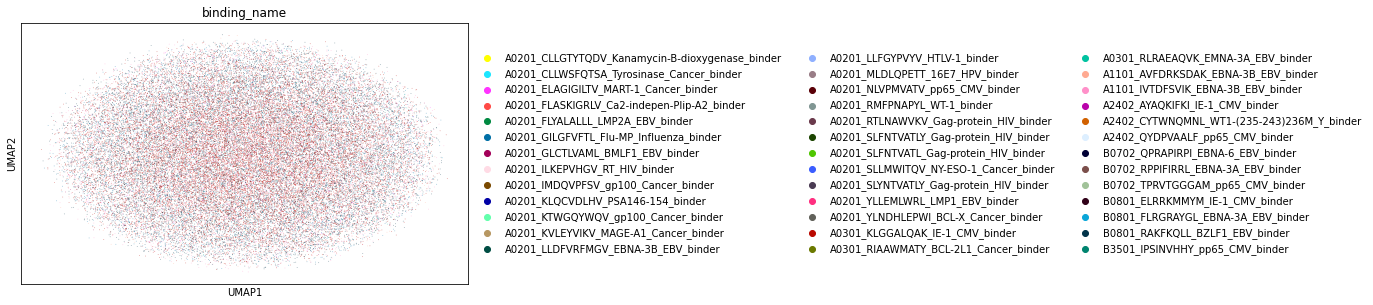

In [25]:
for antigen in high_antigen_count:
    ax = sc.pl.umap(z_train, color=antigen, return_fig=True, alpha=0.3)
    ax.tight_layout()
    experiment.log_figure(figure_name=f'train_{antigen}', figure=ax, overwrite=False)
    ax.clf()
ax = sc.pl.umap(z_train, color='binding_name', return_fig=True, alpha=0.5)
ax.set_size_inches(8, 4.8)
ax.tight_layout()
experiment.log_figure(figure_name=f'train_binding_name', figure=ax, overwrite=False)

# kNN prediction

In [26]:
from sklearn.neighbors import KNeighborsClassifier

def kNN(train_data, test_data, classes, n_neighbors, weights='distance'):
    """
    Perform kNN using scikit-learn package
    :param train_data: annData with features in X and class labels in train_data.obs[classes]
    :param test_data: annData with features in X
    :param classes: key for class labels in train_data.obs[classes]
    :param n_neighbors: number of neighbors for kNN
    :param weights: kNN weights, either 'distance' or 'uniform'
    :return: Writes results into the column test_data.obs['pred_' + classes]
    """
    clf = KNeighborsClassifier(n_neighbors, weights)
    X_train = train_data.X

    # Create categorical labels
    train_data.obs[classes + '_label'] = train_data.obs[classes].astype('category').cat.codes
    mapping = dict(enumerate(train_data.obs[classes].astype('category').cat.categories))
    y_train = train_data.obs[classes + '_label'].values

    clf.fit(X_train, y_train)

    test_data.obs['pred_labels'] = clf.predict(test_data.X)
    test_data.obs['pred_' + classes] = test_data.obs['pred_labels'].map(mapping)


Filter out cells that have rare antigen specificity

In [27]:
classes = 'binding_name'
z_train = z_train[z_train.obs[classes].isin(high_antigen_count)]
z_train.obs[classes].value_counts()

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


A0301_KLGGALQAK_IE-1_CMV_binder            17792
B0801_RAKFKQLL_BZLF1_EBV_binder            12979
A1101_IVTDFSVIK_EBNA-3B_EBV_binder          5390
A0201_GILGFVFTL_Flu-MP_Influenza_binder     5142
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder         1929
A0201_GLCTLVAML_BMLF1_EBV_binder            1027
A0301_RLRAEAQVK_EMNA-3A_EBV_binder           245
A0201_ELAGIGILTV_MART-1_Cancer_binder        144
Name: binding_name, dtype: int64

In [28]:
z_val = z_val[z_val.obs[classes].isin(high_antigen_count)]
z_val.obs[classes].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder            4228
B0801_RAKFKQLL_BZLF1_EBV_binder            1344
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder        1211
A0201_GILGFVFTL_Flu-MP_Influenza_binder    1000
A1101_IVTDFSVIK_EBNA-3B_EBV_binder          150
A0201_GLCTLVAML_BMLF1_EBV_binder             84
A0301_RLRAEAQVK_EMNA-3A_EBV_binder           59
A0201_ELAGIGILTV_MART-1_Cancer_binder        48
Name: binding_name, dtype: int64

In [29]:
kNN(z_train, z_val, classes, 5, 'distance')

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass weights=distance as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [30]:
from sklearn.metrics import classification_report
print(classification_report(z_val.obs[classes], z_val.obs['pred_'+classes]))
experiment.log_text(text=classification_report(z_val.obs[classes], z_val.obs['pred_'+classes]))

COMET WARNING: Empty mapping given to log_params({}); ignoring


                                         precision    recall  f1-score   support

  A0201_ELAGIGILTV_MART-1_Cancer_binder       0.00      0.00      0.00        48
A0201_GILGFVFTL_Flu-MP_Influenza_binder       0.13      0.07      0.09      1000
       A0201_GLCTLVAML_BMLF1_EBV_binder       0.00      0.00      0.00        84
        A0301_KLGGALQAK_IE-1_CMV_binder       0.51      0.51      0.51      4228
     A0301_RLRAEAQVK_EMNA-3A_EBV_binder       0.00      0.00      0.00        59
    A1101_AVFDRKSDAK_EBNA-3B_EBV_binder       0.15      0.01      0.02      1211
     A1101_IVTDFSVIK_EBNA-3B_EBV_binder       0.02      0.08      0.03       150
        B0801_RAKFKQLL_BZLF1_EBV_binder       0.17      0.32      0.22      1344

                               accuracy                           0.33      8124
                              macro avg       0.12      0.12      0.11      8124
                           weighted avg       0.33      0.33      0.32      8124



{'web': 'https://www.comet.ml/api/asset/download?assetId=0c69eda9551246d9b8a67c5b5d984664&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=0c69eda9551246d9b8a67c5b5d984664&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'assetId': '0c69eda9551246d9b8a67c5b5d984664'}

In [31]:
metrics = classification_report(z_val.obs[classes], z_val.obs['pred_'+classes], output_dict=True)
for antigen, metric in metrics.items():
    if antigen != 'accuracy':
        experiment.log_metrics(metric, prefix=antigen)
    else:
        experiment.log_metric('accuracy', metric)

In [32]:
experiment.log_confusion_matrix(matrix=pd.crosstab(z_val.obs[classes], z_val.obs['pred_'+classes]).values,
                                labels=pd.crosstab(z_val.obs[classes], z_val.obs['pred_'+classes]).index.to_list())

{'web': 'https://www.comet.ml/api/asset/download?assetId=6ec49946a0d64794a97837a6c316d7f8&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=6ec49946a0d64794a97837a6c316d7f8&experimentKey=06815a2a65d34e2d8b9e3ace8d67c0a6',
 'assetId': '6ec49946a0d64794a97837a6c316d7f8'}

In [33]:
pd.crosstab(z_val.obs[classes], z_val.obs['pred_'+classes])

pred_binding_name,A0201_ELAGIGILTV_MART-1_Cancer_binder,A0201_GILGFVFTL_Flu-MP_Influenza_binder,A0201_GLCTLVAML_BMLF1_EBV_binder,A0301_KLGGALQAK_IE-1_CMV_binder,A0301_RLRAEAQVK_EMNA-3A_EBV_binder,A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,A1101_IVTDFSVIK_EBNA-3B_EBV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder
binding_name,,,,,,,,
A0201_ELAGIGILTV_MART-1_Cancer_binder,0,6,0,24,0,0,4,14
A0201_GILGFVFTL_Flu-MP_Influenza_binder,0,73,6,528,0,17,70,306
A0201_GLCTLVAML_BMLF1_EBV_binder,0,6,0,42,0,0,6,30
A0301_KLGGALQAK_IE-1_CMV_binder,1,287,26,2148,2,55,306,1403
A0301_RLRAEAQVK_EMNA-3A_EBV_binder,0,2,0,38,0,1,6,12
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,0,80,8,636,0,15,90,382
A1101_IVTDFSVIK_EBNA-3B_EBV_binder,0,7,0,82,0,2,12,47
B0801_RAKFKQLL_BZLF1_EBV_binder,3,101,5,676,1,13,109,436


In [34]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/tcr/10x-baseline/06815a2a65d34e2d8b9e3ace8d67c0a6
COMET INFO:   Metrics:
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_f1-score    : 1
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_precision   : 1
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_recall      : 1
COMET INFO:     A0201_ELAGIGILTV_MART-1_Cancer_binder_support     : 48
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_f1-score  : 0.09346991037131881
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_precision : 0.1298932384341637
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_recall    : 0.073
COMET INFO:     A0201_GILGFVFTL_Flu-MP_Influenza_binder_support   : 1000
COMET INFO:     A0201_GLCTLVAML_BMLF1_EBV_binder_f1-score         : 1
COMET INFO: